In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated

from ellipse_utils import (
    ellipsify,
    get_ellipse_patch,
    sample_2d_circle,
)

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}
seed = 1
torch.manual_seed(seed)
num_samples = 1000
base_samples = sample_2d_circle(n=num_samples, **tkwargs)

In [3]:
# Get the feasible objective space.
radii = torch.tensor(
    [
        [0.85, 0.40],
        [0.70, 0.50],
        [0.30, 0.90],
    ],
    **tkwargs
)

angles = torch.tensor([-0.20 * torch.pi, -0.00 * torch.pi, -0.0 * torch.pi], **tkwargs)

translates = torch.tensor(
    [
        [-0.275, 0.10],
        [0.20, -0.0],
        [0.00, 0.0],
    ],
    **tkwargs
)

samples = []
for i in range(len(radii)):
    samples.append(
        ellipsify(
            base_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

# Get the Pareto front.
num_surface_samples = 2**10
t = torch.linspace(0, 1, num_surface_samples, **tkwargs)
surface_samples = torch.column_stack(
    [torch.cos(2 * torch.pi * t), torch.sin(2 * torch.pi * t)]
)
p_samples = []
for i in range(len(radii)):
    p_samples.append(
        ellipsify(
            surface_samples, radius=radii[i], angle=angles[i], translate=translates[i]
        )
    )

p_samples = torch.row_stack(p_samples)
p_samples = p_samples[is_non_dominated(p_samples)]
p_samples = p_samples[p_samples[:, 0].argsort()]

nadir = torch.zeros(1, 2, **tkwargs)

# Get Chebyshev contours.

weights = torch.tensor([0.55, 0.45], **tkwargs)
weights = weights / torch.norm(weights, p=2)

t = torch.linspace(-5, 5, 101, **tkwargs).unsqueeze(-1)
line = nadir + t * weights

scalarization_fn = LengthScalarization(weights=weights, ref_points=nadir)
grid_length = 128
num_points = grid_length * grid_length

g1 = torch.linspace(-0.1, 1.1, grid_length).to(**tkwargs)
g2 = torch.linspace(-0.1, 1.1, grid_length).to(**tkwargs)
X, Y = torch.meshgrid(g1, g2, indexing="xy")

Z = torch.column_stack(
    [X.reshape(grid_length * grid_length), Y.reshape(grid_length * grid_length)]
)
Z = scalarization_fn(Z).reshape(grid_length, grid_length)

# Get the best points.
best_point = p_samples[scalarization_fn(p_samples).argmax()]
max_value = 2
best_contour = torch.tensor(
    [
        [best_point[0], max_value],
        [best_point[0], best_point[1]],
        [max_value, best_point[1]],
    ],
    **tkwargs
)

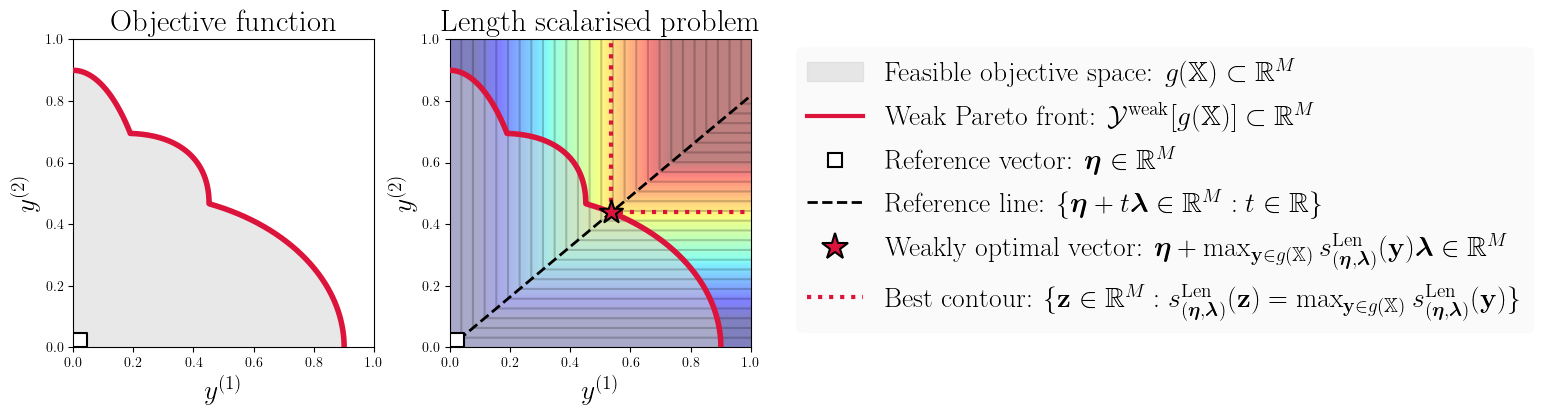

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8.75, 4))

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.25, hspace=0.15
)

plt.subplot(1, 2, 1)
plt.plot(p_samples[:, 0], p_samples[:, 1], color="crimson", zorder=5, linewidth=4)
plt.fill_between(
    p_samples[:, 0],
    -1 * torch.ones_like(p_samples[:, 0]),
    p_samples[:, 1],
    color="lightgray",
    alpha=0.5,
)
plt.title("Objective function", fontsize=22)

#########################################################################################
plt.subplot(1, 2, 2)
plt.plot(p_samples[:, 0], p_samples[:, 1], color="crimson", zorder=3, linewidth=4)
plt.fill_between(
    p_samples[:, 0],
    -1 * torch.ones_like(p_samples[:, 0]),
    p_samples[:, 1],
    color="lightgray",
    alpha=0.5,
)

plt.contour(X, Y, Z, colors="black", alpha=0.2, levels=32)
img = plt.imshow(
    Z,
    extent=[-0.00, 1, -0.00, 1],
    origin="lower",
    cmap="jet",
    alpha=0.5,
    vmin=0.0,
    vmax=1.0,
    aspect="auto",
)

plt.plot(line[:, 0], line[:, 1], linestyle="--", color="k", zorder=4, linewidth=2)

plt.scatter(
    best_point[0],
    best_point[1],
    color="crimson",
    marker="*",
    linestyle="None",
    s=300,
    edgecolors="k",
    linewidth=1.5,
    zorder=5,
)

plt.plot(
    best_contour[:, 0],
    best_contour[:, 1],
    linestyle=":",
    color="crimson",
    zorder=4,
    linewidth=3,
)
plt.title("Length scalarised problem", fontsize=22)

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.scatter(
        nadir[:, 0] + 0.025,
        nadir[:, 1] + 0.025,
        color="w",
        marker="s",
        linestyle="None",
        s=100,
        edgecolors="k",
        linewidth=1.5,
        zorder=5,
    )

    plt.xlim(-0.0, 1)
    plt.ylim(-0.0, 1)
    plt.xlabel(r"$y^{(1)}$", fontsize=20)
    plt.ylabel(r"$y^{(2)}$", fontsize=20)
#########################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=1.5,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

red_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle="-",
    alpha=1.0,
    linewidth=3,
    label=r"Weak Pareto front: $\mathcal{Y}^{\text{weak}}[g(\mathbb{X})] \subset \mathbb{R}^M$",
)

gray_patch = mpatches.Patch(
    color="lightgray",
    alpha=0.5,
    label=r"Feasible objective space: $g(\mathbb{X}) \subset \mathbb{R}^M$",
)

red_star = mlines.Line2D(
    [],
    [],
    color="crimson",
    marker="*",
    linestyle="None",
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=1.5,
    label=r"Weakly optimal vector: $\boldsymbol{\eta} + \max_{\mathbf{y} \in g(\mathbb{X})} s^{\text{Len}}_{(\boldsymbol{\eta}, \boldsymbol{\lambda})}(\mathbf{y}) \boldsymbol{\lambda} \in \mathbb{R}^M$",
)

red_dotted_line = mlines.Line2D(
    [],
    [],
    color="crimson",
    linestyle=":",
    linewidth=3,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Best contour: $\{\mathbf{z} \in \mathbb{R}^M: s^{\text{Len}}_{(\boldsymbol{\eta}, \boldsymbol{\lambda})}(\mathbf{z}) = \max_{\mathbf{y} \in g(\mathbb{X})} s^{\text{Len}}_{(\boldsymbol{\eta}, \boldsymbol{\lambda})}(\mathbf{y})\}$",
)

black_line = mlines.Line2D(
    [],
    [],
    color="k",
    linestyle="--",
    linewidth=2,
    markersize=20,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference line: $\{\boldsymbol{\eta} + t \boldsymbol{\lambda} \in \mathbb{R}^M: t \in \mathbb{R}\}$",
)


axes[1].legend(
    handles=[gray_patch, red_line, white_square, black_line, red_star, red_dotted_line],
    ncol=1,
    fontsize=20,
    loc=(1.15, 0.05),
    facecolor="k",
    framealpha=0.02,
)


plt.show()